In [1]:
import camelot
from pypdf import PdfReader
import matplotlib.pyplot as plt
from itertools import chain
from datetime import datetime
import csv

from beancount.core import amount, data
from beancount.core.number import D

# sbbImporter.parse_pdf_to_csv(pdf_file, csv_file)

In [2]:
pdf_file = '/home/carlosvigo/Documents/Finances/Records/Assets/Current/SBB/HFTPlus/2024-12-31-SBB_Tickets.pdf'
csv_file = '/tmp/test.csv'

# get number of pages
reader = PdfReader(pdf_file)
n_pages = len(reader.pages)

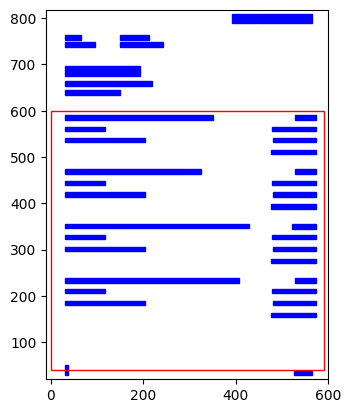

16 rows


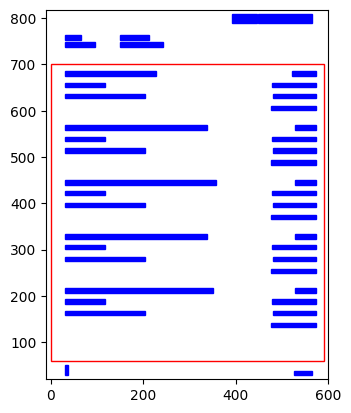

20 rows


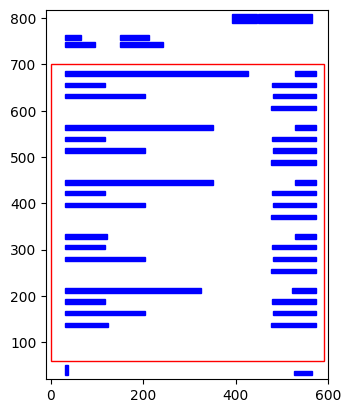

20 rows


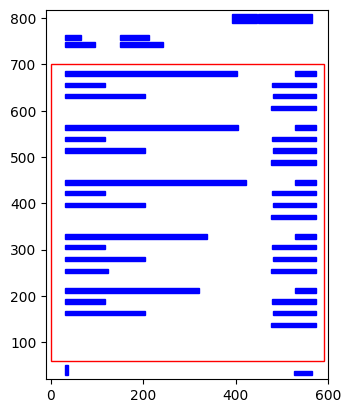

20 rows


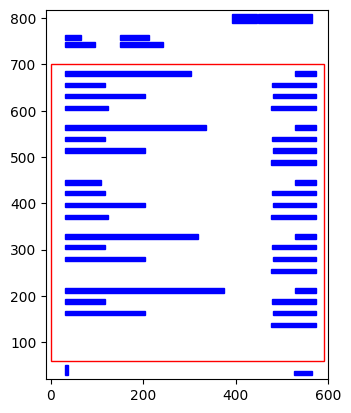

20 rows


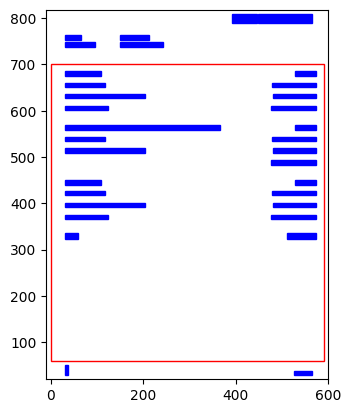

13 rows


In [9]:
# read the different pages
first_table = camelot.read_pdf(
    pdf_file,
    pages='1',
    flavor="stream",
    table_areas=["0,600,590,40"],
    columns=['470']
)

table_areas = ["0,700,590,60"]
# Case 1: one pages
if n_pages == 1:
        tables = first_table
# Case 2: two pages
elif n_pages == 2:
    last_table = camelot.read_pdf(
        pdf_file,
        pages='2',
        flavor="stream",
        table_areas=table_areas,
        columns=['470']
    )
    tables = chain(first_table, last_table)
# Case 3: more than two pages
else:
    mid_tables = camelot.read_pdf(
        pdf_file,
        pages='2-{}'.format(n_pages-1),
        flavor="stream",
        table_areas=table_areas,
        columns=['470']
    )
    last_table = camelot.read_pdf(
        pdf_file,
        pages='{}'.format(n_pages),
        flavor="stream",
        table_areas=table_areas,
        columns=['470']
    )
    tables = chain(first_table, mid_tables, last_table)

tables = list(tables)

for index, table in enumerate(tables):
    camelot.plot(table, kind='contour')
    plt.show()
    n_rows = table.df.shape[0]
    print('{} rows'.format(n_rows))
    if index == len(tables) - 1:
        assert (n_rows - 1) % 4 == 0
    else:
        assert n_rows % 4 == 0


In [10]:
# Process tables into individual orders
orders = []
balance = None
for index, table in enumerate(tables):
    table = table.df.values.tolist()
    if index == len(tables)-1:
        n_rows = len(table) - 1
        balance = table[-1]
    else:
        n_rows = len(table)
        
    assert n_rows % 4 == 0
    orders.extend([table[i:i+4] for i in range(0, n_rows-1, 4)])

orders = [[item for sublist in order for item in sublist] for order in orders]
print(orders[0])
print(orders[-1])
print(balance)

['ZVV Single Ticket Zürich Flughafen - Zürich, Sprecherstrasse', '3.50 CHF', 'Traveller: Carlos Vigo', 'Travel date: 25.05.2024', 'Delivery address: carviher1990@gmail.com', 'Order date: 26.05.2024', '', 'Order no.: 90171038362']
['ZVV 24h-Ticket', '6.40 CHF', 'Traveller: Carlos Vigo', 'Travel date: 10.01.2024', 'Delivery address: carviher1990@gmail.com', 'Order date: 10.01.2024', 'Payment type: PLU null', 'Order no.: 72000528643']
['Total', '179.40 CHF']


In [11]:
# Process orders into transactions
transactions = []
special_char_map = {ord('ä'):'ae', ord('ü'):'ue', ord('ö'):'oe', ord('ß'):'ss'}

for order in orders:
    # Parse fields
    description = order[0].translate(special_char_map)
    cost = amount.Amount(D(order[1].split()[0]), order[1].split()[1])
    traveller = order[2].replace('Traveller: ', '')
    travel_date = datetime.strptime(order[3], "Travel date: %d.%m.%Y").date()
    delivery_address = order[4].replace('Delivery address: ', '')
    order_date = datetime.strptime(order[5], "Order date: %d.%m.%Y").date()
    order_num = int(order[7].replace('Order no.: ', ''))

    transactions.append([
        order_date,
        travel_date,
        description,
        cost[0],
        cost[1],
        traveller,
        delivery_address,
        order_num
        ])

print(transactions[0])
print(transactions[-1])

[datetime.date(2024, 5, 26), datetime.date(2024, 5, 25), 'ZVV Single Ticket Zuerich Flughafen - Zuerich, Sprecherstrasse', Decimal('3.50'), 'CHF', 'Carlos Vigo', 'carviher1990@gmail.com', 90171038362]
[datetime.date(2024, 1, 10), datetime.date(2024, 1, 10), 'ZVV 24h-Ticket', Decimal('6.40'), 'CHF', 'Carlos Vigo', 'carviher1990@gmail.com', 72000528643]


In [12]:
# Save to CSV
# Write to CSV file
with open(csv_file, 'wt') as f:
    # Header
    f.write('Order Date; Travel Date; Description; Value; Currency; Traveller; Delivery Address; Order Number\n')

    # Transactions
    for transaction in transactions:
        f.write('{};{};{};{};{};{};{};{}\n'.format(*transaction))

In [13]:
# Read the CSV file
with open(str(csv_file), 'r') as csvfile:
    reader = csv.reader(
        csvfile,
        delimiter=";"
    )
    rows = list(reader)

In [14]:
entries = []
sbb_account = 'Assets:SBB'

# Build beancount entries
for line_number, row in enumerate(rows[2:]):
    entries.append(data.Transaction(
        data.new_metadata(
            filename=pdf_file,
            lineno=line_number,
            kvlist=dict({
                'orderno': row[7],
                'traveller': row[5],
                'email': row[6],
                'travel_date': row[1]
            })),
        row[0],
        "*",
        "SBB",
        row[2],
        data.EMPTY_SET,
        data.EMPTY_SET,
        [data.Posting(sbb_account, amount.Amount(-D(row[3]), row[4]), None, None, None, None)],
    ))

print(entries[0])

Transaction(meta={'filename': '/home/carlosvigo/Documents/Finances/Records/Assets/Current/SBB/HFTPlus/2024-12-31-SBB_Tickets.pdf', 'lineno': 0, 'orderno': '86992838222', 'traveller': 'Carlos Vigo', 'email': 'carviher1990@gmail.com', 'travel_date': '2024-05-04'}, date='2024-05-05', flag='*', payee='SBB', narration='ZVV Single Ticket Zuerich Stadelhofen - Zuerich Flughafen', tags=frozenset(), links=frozenset(), postings=[Posting(account='Assets:SBB', units=-3.50 CHF, cost=None, price=None, flag=None, meta=None)])
